In [33]:
import numpy as np
import math
import time
import matplotlib.pyplot as plt

In [34]:
def clipped_poisson(lam, max_k):
    """
    Return poisson PMF clipped at max_k with remaining tail probability
    placed at max_k.
    """
    pmf = np.zeros(max_k + 1)
    for k in range(max_k):
        pmf[k] = math.exp(-lam) * lam**k / math.factorial(k)
    pmf[max_k] = 1 - np.sum(pmf)
    
    return pmf     

In [35]:
def build_rent_return_pmf(lambda_request, lambda_return, max_cars):
    """
    Return p(new_rentals, returns | initial_cars) as numpy array:
        p[initial_cars, new_rentals, returns]
    """
    pmf = np.zeros((max_cars+1, max_cars+1, max_cars+1))
    
    for init_cars in range(max_cars + 1):
        new_rentals_pmf = clipped_poisson(lambda_request, init_cars)
        for new_rentals in range(init_cars + 1):
            max_returns = max_cars - init_cars + new_rentals
            returns_pmf = clipped_poisson(lambda_return, max_returns)
            for returns in range(max_returns + 1):
                p = returns_pmf[returns] * new_rentals_pmf[new_rentals]
                pmf[init_cars, new_rentals, returns] = p
                
    return pmf

In [36]:
class JacksWorld(object):
    """Environment model of Jack's Car Rental"""
    def __init__(self, lambda_return1, lambda_return2,
                 lambda_request1, lambda_request2, max_cars):
        # pre-build the rentals/returns pmf for each location
        self.rent_return_pmf = []
        self.rent_return_pmf.append(build_rent_return_pmf(lambda_request1,
                                                      lambda_return1,
                                                      max_cars))
        self.rent_return_pmf.append(build_rent_return_pmf(lambda_request2,
                                                      lambda_return2,
                                                      max_cars))
        self.max_cars = max_cars
        
    def get_transition_model(self, s, a):
        """
        Return 2-tuple:
            1. p(s'| s, a) as dictionary:
                keys = s'
                values = p(s' | s, a)
            2. E(r | s, a, s') as dictionary:
                keys = s'
                values = E(r | s, a, s')
        """
        s = (s[0] - a, s[1] + a)         # move a cars from loc1 to loc2
        move_reward = -math.fabs(a) * 2  # ($2) per car moved
        t_prob, expected_r = ([{}, {}], [{}, {}])
        for loc in range(2):
            morning_cars = s[loc]
            rent_return_pmf = self.rent_return_pmf[loc]
            for rents in range(morning_cars + 1):
                max_returns = self.max_cars - morning_cars + rents
                for returns in range(max_returns + 1):
                    p = rent_return_pmf[morning_cars, rents, returns]
                    if p < 1e-5:
                        continue
                    s_prime = morning_cars - rents + returns
                    r = rents * 10
                    t_prob[loc][s_prime] = t_prob[loc].get(s_prime, 0) + p
                    expected_r[loc][s_prime] = expected_r[loc].get(s_prime, 0) + p * r
        
        # join probabilities and expectations from loc1 and loc2
        t_model, r_model = ({}, {})
        for s_prime1 in t_prob[0]:
            for s_prime2 in t_prob[1]:
                p1 = t_prob[0][s_prime1]  # p(s' | s, a) for loc1
                p2 = t_prob[1][s_prime2]  # p(s' | s, a) for loc2
                t_model[(s_prime1, s_prime2)] = p1 * p2
                # expectation of reward calculated using p(s', r | s, a)
                # need to normalize by p(s' | s, a)
                norm_E1 = expected_r[0][s_prime1] / p1
                norm_E2 = expected_r[1][s_prime2] / p2
                r_model[(s_prime1, s_prime2)] = norm_E1 + norm_E2 + move_reward
        return t_model, r_model

In [37]:
# Initialize environment
max_cars = 20
jacks = JacksWorld(lambda_return1=3, lambda_return2=6,
                 lambda_request1=4, lambda_request2=5, max_cars=max_cars)

# Initialize value function
V = np.zeros((max_cars+1, max_cars+1))
states = [(s0, s1) for s0 in range(max_cars+1) for s1 in range(max_cars+1)]
gamma = 0.8

start_time = time.time()
# Value Iteration
theta = 0.5         # V(s) delta stopping threshold
print('Worst |V_old(s) - V(s)| delta:')
for k in range(100):
    delta = 0
    V_old = V.copy()
    V = np.zeros((max_cars+1, max_cars+1))
    for s in states:
        v_best = -1000
        max_a = min(5, s[0], max_cars-s[1])
        min_a = max(-5, -s[1], -(max_cars-s[0]))
        for a in range(min_a, max_a+1):
            t_model, r_model = jacks.get_transition_model(s, a)            
            v_new = 0
            for s_prime in t_model:
                p = t_model[s_prime]
                r = r_model[s_prime]
                # must use previous iteration's V(s): V_old(s)
                v_new += p * (gamma * V_old[s_prime] + r)
            v_best = max(v_best, v_new)
        V[s] = v_best
        delta = max(delta, abs(V[s] - V_old[s]))
    print('Iteration {}: max delta = {:.2f}'.format(k, delta))
    if delta < theta: break
    
# Extract Policy from V(s)
pi = np.zeros((max_cars+1, max_cars+1), dtype=np.int16)
for s in states:
    best_v = -1000
    max_a = min(5, s[0], max_cars-s[1])
    min_a = max(-5, -s[1], -(max_cars-s[0]))
    for a in range(min_a, max_a+1):
        t_model, r_model = jacks.get_transition_model(s, a)
        v = 0
        for s_prime in t_model:
            p = t_model[s_prime]
            r = r_model[s_prime]
            v += p * (gamma * V[s_prime] + r)
        if v > best_v:
            pi[s] = a
            best_v = v

Worst |V_old(s) - V(s)| delta:
Iteration 0: max delta = 89.98
Iteration 1: max delta = 71.95
Iteration 2: max delta = 57.54
Iteration 3: max delta = 45.98
Iteration 4: max delta = 36.71
Iteration 5: max delta = 29.28
Iteration 6: max delta = 23.34
Iteration 7: max delta = 18.59
Iteration 8: max delta = 14.81
Iteration 9: max delta = 11.80
Iteration 10: max delta = 9.40
Iteration 11: max delta = 7.49
Iteration 12: max delta = 5.97
Iteration 13: max delta = 4.76
Iteration 14: max delta = 3.79
Iteration 15: max delta = 3.02
Iteration 16: max delta = 2.41
Iteration 17: max delta = 1.93
Iteration 18: max delta = 1.54
Iteration 19: max delta = 1.23
Iteration 20: max delta = 0.98
Iteration 21: max delta = 0.78
Iteration 22: max delta = 0.62
Iteration 23: max delta = 0.50


In [38]:
print('\nValue iteration done, final policy:')            
print(pi)         
print("\n--- {:.2f} seconds ---".format(time.time() - start_time))


Value iteration done, final policy:
[[ 0  0  0  0  0 -1 -2 -2 -3 -3 -4 -4 -5 -5 -5 -5 -5 -5 -5 -5 -5]
 [ 0  0  0  0  0 -1 -1 -2 -2 -3 -3 -4 -4 -4 -5 -5 -5 -5 -5 -5 -5]
 [ 0  0  0  0  0  0 -1 -1 -2 -2 -3 -3 -3 -4 -4 -4 -4 -5 -5 -5 -5]
 [ 0  0  0  0  0  0  0 -1 -1 -2 -2 -2 -3 -3 -3 -3 -4 -4 -4 -4 -4]
 [ 1  0  0  0  0  0  0  0 -1 -1 -1 -2 -2 -2 -2 -3 -3 -3 -3 -3 -3]
 [ 1  1  1  0  0  0  0  0  0  0 -1 -1 -1 -1 -2 -2 -2 -2 -2 -2 -2]
 [ 2  2  1  1  0  0  0  0  0  0  0  0  0 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 3  2  2  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 3  3  2  2  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 4  3  3  2  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 4  4  3  2  2  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 5  4  3  3  2  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 5  4  4  3  2  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 5  5  4  3  2  2  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 5  5  4  3  3  2  1  0  0  0  0  0  

In [39]:
print(V)

[[304.01539712 313.97748486 323.7636446  333.09147893 341.63000975
  349.54708279 357.13148842 364.62641223 371.47699163 377.79645976
  383.55875319 388.70868291 393.18289399 397.27358063 400.61567287
  403.38871326 405.70725091 407.65368258 409.29054539 410.663119
  411.80523577]
 [313.93533262 323.89724123 333.68308594 343.01007475 351.54696345
  359.13135912 366.62631036 373.47685042 379.7963396  385.55863303
  390.70855252 395.18276361 399.27347022 402.61554764 405.63923135
  408.2286328  410.36803128 412.14499982 413.62563835 414.85760291
  415.87593815]
 [323.53162024 333.49322619 343.27795452 352.60155515 361.13122981
  368.6262085  375.47670921 381.79621945 387.55851287 392.70842214
  397.18263322 401.27335981 404.61542241 407.63908886 410.22850219
  412.36790223 414.14484635 415.71888905 417.04251623 418.13298731
  419.02659865]
 [332.44212412 342.40303735 352.18495953 361.50015868 370.01184959
  377.476568   383.79609929 389.55839271 394.70829175 399.18250284
  403.2732494  4

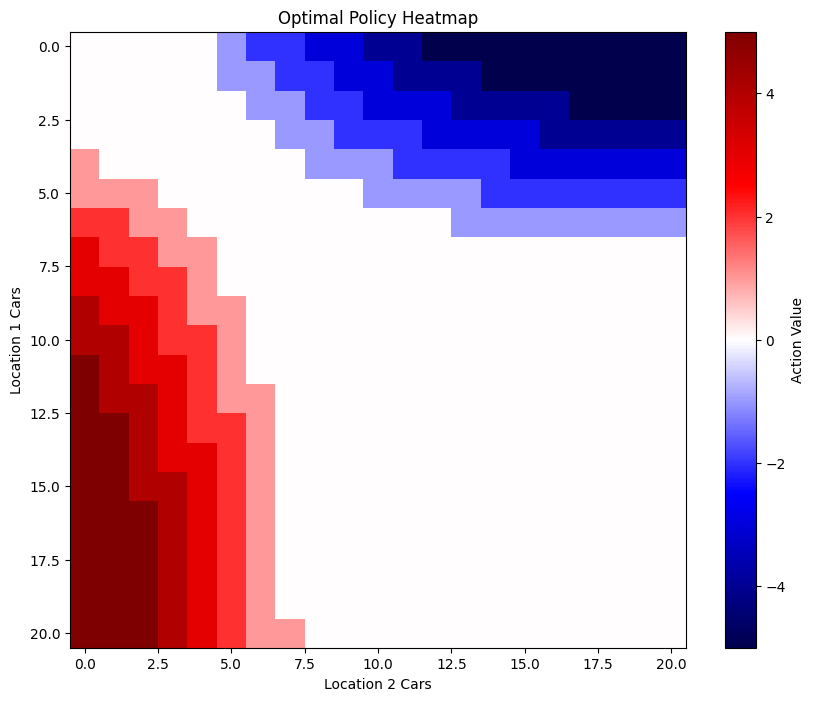

In [40]:
# Create the heatmap
heatmap = pi
plt.figure(figsize=(10, 8))
plt.imshow(heatmap, cmap='seismic', vmin=-5, vmax=5)
plt.colorbar(label='Action Value')
plt.xlabel('Location 2 Cars')
plt.ylabel('Location 1 Cars')
plt.title('Optimal Policy Heatmap')
plt.show()